In [1]:
from sklearn.metrics import RocCurveDisplay
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import safetensors
from tqdm import tqdm

In [2]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
class CustomModel(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        activation_layer = nn.ReLU
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(840 * 4, 1024),
            activation_layer(),
            nn.Linear(1024, 128),
            activation_layer(),
            nn.Linear(128, 1),
            # nn.Sigmoid()
        )
        self.loss_fn = nn.BCEWithLogitsLoss()
    
    def forward(self, inputs, labels=None):
        # print(inputs, labels)
        inputs = inputs.to(self._dtype())
        logits = self.net(inputs).squeeze()
        if labels is not None:
            labels = labels.to(logits.dtype)
            loss = self.loss_fn(logits, labels)
            return {"loss": loss, "logits": logits}
        return {"logits": logits}
    
    def _dtype(self):
        return self.net[1].weight.dtype

In [4]:
safe = safetensors.safe_open('models/trained_model/model.safetensors', framework='pt', device=0)

In [5]:
state_dict = {key: safe.get_tensor(key) for key in safe.keys()}

In [6]:
model = CustomModel().to(device)
model.load_state_dict(state_dict)
model.eval()

CustomModel(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3360, out_features=1024, bias=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=1, bias=True)
  )
  (loss_fn): BCEWithLogitsLoss()
)

In [7]:
model

CustomModel(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3360, out_features=1024, bias=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=1, bias=True)
  )
  (loss_fn): BCEWithLogitsLoss()
)

In [8]:
class LabeledDataset(Dataset):
    def __init__(self, ds: Dataset, active_label: int = 1):
        super().__init__()
        self.ds = ds
        self.active_label = active_label
    
    def __getitem__(self, index):
        sample = self.ds.__getitem__(index)
        return {'inputs': sample[0], 'labels': sample[self.active_label]}
    
    def __len__(self):
        return len(self.ds)

In [9]:
ds = torch.load('data/dataset.pt', weights_only=False)
ds = LabeledDataset(ds)
generator = torch.Generator().manual_seed(42)
splits = random_split(ds, [.8, .1, .1], generator)
ds = {
    'train': splits[0],
    'dev': splits[1],
    'test': splits[2]
}

In [10]:
dl = DataLoader(ds['test'], batch_size=1024, shuffle=False, pin_memory=True)

In [11]:
y_true = []
y_pred = []

with torch.no_grad():
    for batch in tqdm(dl, desc='Evaluating'):
        y_true.append(batch['labels'])
        X_batch = batch['inputs'].to(device)
        logits = model(X_batch)['logits']
        y_pred.append(nn.functional.sigmoid(logits).cpu())

y_true = torch.cat(y_true)
y_pred = torch.cat(y_pred)
    

Evaluating: 100%|██████████| 4/4 [00:00<00:00,  7.52it/s]


In [12]:
y_pred

tensor([3.3948e-04, 9.9900e-01, 2.3891e-02,  ..., 9.9847e-01, 9.9996e-01,
        9.9631e-01])

[Text(0.5, 0, 'False Positive Rate'),
 Text(0, 0.5, 'True Positive Rate'),
 Text(0.5, 1.0, 'ROC lung cancer Classification')]

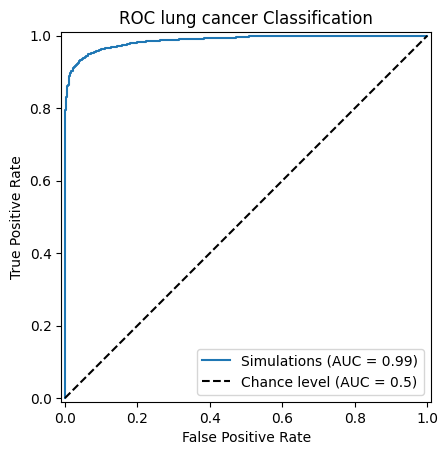

In [13]:
display = RocCurveDisplay.from_predictions(
    y_true,
    y_pred,
    name=f"Simulations",
    plot_chance_level=True,
    # despine=True,
)
display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="ROC lung cancer Classification",
)